Step 1000: [[-0.03809058 -0.15006752 -0.27309028 -0.33583202 -0.38658342 -0.3507716
  -0.3354144  -0.30902063 -0.35866147 -0.3145185 ]
 [ 0.21955496  0.23051884  0.22411021  0.23077092  0.19521163  0.17908763
   0.10016186  0.02295815 -0.0421149  -0.13460311]
 [-0.24896155 -0.13155526 -0.08559668 -0.05502582  0.04886061  0.04835944
   0.04051008  0.12084207  0.20834632  0.42344561]
 [-0.18308507 -0.16149883 -0.12550111 -0.06810589 -0.04562238 -0.06604111
  -0.03417578  0.03668269  0.07193619  0.20066675]
 [ 0.5187779   0.49501249  0.45754299  0.44082726  0.37685692  0.30803962
   0.19493434  0.00153963 -0.20022829 -0.37230936]
 [ 0.01999516 -0.0481051  -0.12689256 -0.1167527  -0.09516219 -0.10770911
  -0.11201759 -0.12538815 -0.13336564 -0.1644591 ]
 [-0.27848054 -0.15189541 -0.08616641 -0.01241853  0.00288561  0.04537996
   0.07216757  0.14675051  0.24133646  0.5092875 ]
 [ 0.24113205  0.16632416  0.12910656  0.10047589  0.08087988  0.04290734
   0.04750627  0.03969274  0.05477083  0.

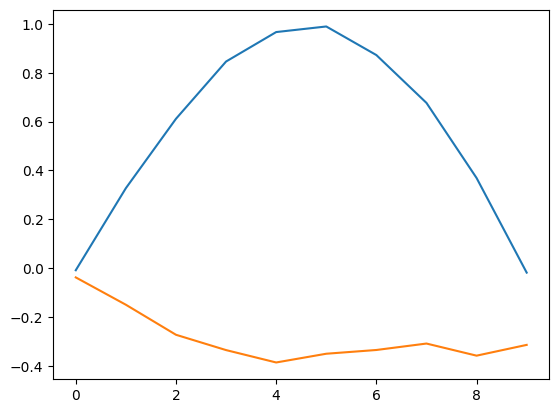

In [590]:
import torch
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

class BurgersDynamics:
    def __init__(self, num_points, viscosity, dt, dx) -> None:
        self.num_points = num_points
        self.viscosity = viscosity
        self.dt = dt
        self.dx = dx
        self.u = torch.zeros(num_points).double()  # Initial state
        self.A, self.B = self.generate_dynamics()
        self.D = self.generate_difference_matrix()

    def generate_dynamics(self) -> Tuple[torch.Tensor, torch.Tensor]:
        A = torch.eye(self.num_points).double()
        for i in range(1, self.num_points - 1):
            A[i, i-1] = self.viscosity * self.dt / self.dx**2
            A[i, i] = 1 - 2 * self.viscosity * self.dt / self.dx**2
            A[i, i+1] = self.viscosity * self.dt / self.dx**2

        #B = torch.zeros(self.num_points, 3).double()
        #B[0, 0] = self.dt / self.dx
        #B[self.num_points // 2, 1] = self.dt / self.dx
        #B[-1, 2] = self.dt / self.dx
        B = torch.eye(self.num_points).double() * (self.dt / self.dx)

        return A, B

    def generate_difference_matrix(self) -> torch.Tensor:
        D = torch.zeros(self.num_points, self.num_points).double()
        for i in range(1, self.num_points-1):
            D[i, i-1] = -0.5 * self.dt / self.dx
            D[i, i+1] = 0.5 * self.dt / self.dx
        return D

    def reset(self, n_samples: int = 1) -> torch.Tensor:
        x = torch.linspace(0, 1, self.num_points).double()
        self.u = torch.sin(np.pi * x).repeat(n_samples, 1)
        noise = torch.normal(0, 0.001, size=self.u.shape).double()
        self.u += noise  # Add small Gaussian noise
        return self.u

    def step(self, u: torch.Tensor) -> torch.Tensor:
        # Update the state using the dynamics
        noise = torch.normal(0, 0.01, size=self.u.shape).double()
        #self.u = self.u @ self.A.T + u @ self.B.T - (self.u ** 2) @ self.D.T + noise
        self.u = self.u @ self.A.T + u * (self.dt / self.dx) - (self.u ** 2) @ self.D.T + noise
        return self.u

# Parameters
num_points = 10
viscosity = 0.1
dt = 0.01
dx = 1.0 / (num_points - 1)

# Create the dynamics environment
dynamics = BurgersDynamics(num_points, viscosity, dt, dx)

# Reset the state
state = dynamics.reset(10)

# Run simulation for multiple steps
n_steps = 1000
control_input = 0.0 * torch.ones((num_points)).double()  # No control input

states = []
for step in range(n_steps):
    state = dynamics.step(control_input)
    states.append(state[0])
states = torch.stack(states)
print(f"Step {step + 1}: {state.numpy()}")

plt.plot(states[0])
plt.plot(states[-1])
plt.show()

In [562]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [563]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [564]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.addpgpd_sampled import ADpgpdSampled
from src.algorithms.nnpgpd import Nnpgpd
from src.sampling import Sampler

In [565]:
ds = 10
da = 10

tau = 0.01
gamma = 0.9
alpha = 1.0

b = -1

In [566]:
G = - torch.diag(torch.tensor([1.0] * ds)).double()
R =  - torch.diag(torch.tensor([0.1] * da)).double() * (tau / 2)
C = - torch.eye(da).double()

def primal_reward_fn(env, a):
    return ((env.u @ G) * env.u).sum(dim=1) + ((a @ R) * a).sum(dim=1)

def dual_reward_fn(env, a):
    return (a.abs() @ C).sum(dim=1)

def starting_pos_fn(n_samples):
        rng = np.random.default_rng()

        x = torch.linspace(0, 1, ds).double()
        u = torch.sin(np.pi * x).repeat(n_samples, 1)
        noise = torch.normal(0, 0.01, size=u.shape).double()
        u += noise

        a = torch.tensor(rng.uniform(
            low=[-1] * da,
            high=[1] * da,
            size=[n_samples, da],
        )).double()

        return u, a

In [594]:
epochs = 1_000
n_pe = 100
n_rho = 100
n_roll = 400

gamma = 0.99
eta = 0.0001

viscosity = 0.1
dt = 0.01
dx = 1.0 / (ds - 1)

env = BurgersDynamics(ds, viscosity, dt, dx)

sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

KeyboardInterrupt: 

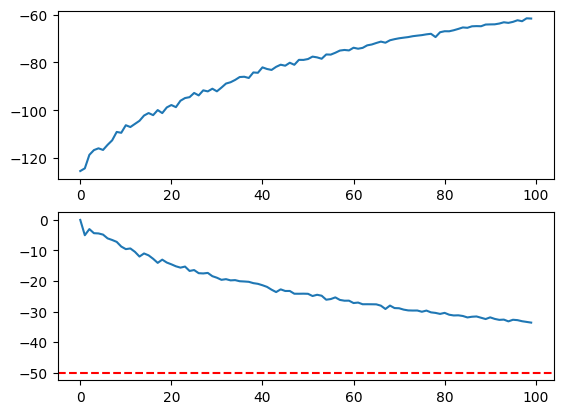

In [593]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
#axes[0].axhline(y=-910, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

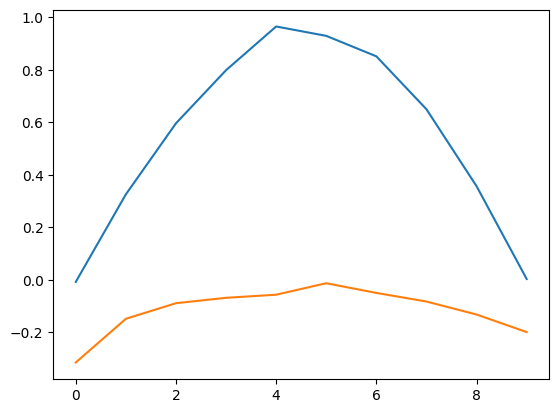

In [606]:
state = env.reset(1)
states = []
for step in range(1000):
    control_input = state @ K.T
    state = env.step(control_input)
    states.append(state[0])
states = torch.stack(states)

plt.plot(states[0])
plt.plot(states[-1])
plt.show()

In [580]:
epochs = 150_000
n_pe = 100
n_rho = 200
n_roll = 400

gamma = 0.99
eta = 0.00001

viscosity = 0.1
dt = 0.001
dx = 1.0 / (ds - 1)

b = -50

env = BurgersDynamics(ds, viscosity, dt, dx)

sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

KeyboardInterrupt: 

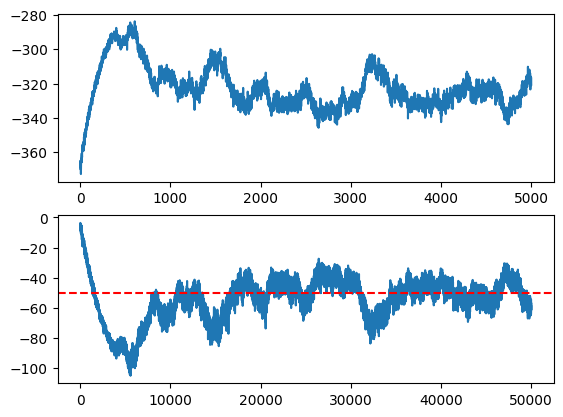

In [579]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
#axes[0].axhline(y=-910, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

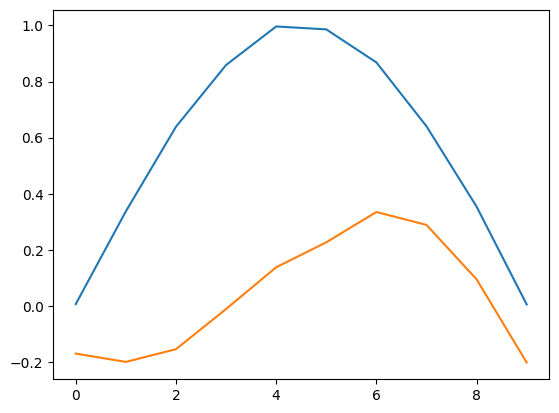

In [520]:
state = env.reset(1)
states = []
for step in range(400):
    control_input = state @ K.T
    state = env.step(control_input)
    states.append(state[0])
states = torch.stack(states)

plt.plot(states[0])
plt.plot(states[-1])
plt.show()